### Model training Script:

### Pipeline for training an ML model for food classification task in 14 food classes.
* The objective is achieved using Inception V3 NN architecture initialized with Imagenet weights and retrained for 12 epochs.

#### Following program serves following purposes:
* Iteratively renames all images in different subdirectories accordingly their class names for convenience.
* Adds all image paths into a dataframe and correspondingly assigns a numeric class label for each using produce_label function.
* Performs preprocessing and train-test split on training images before parsing them through the model to ouput predicted lables.
* defines a network using Inception V3 architecture initilaized with Imagenet weights. 
* retrains the network for 12 iterations end to end, using gradient decent with momentum and learning rate decay.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imresize

%matplotlib inline
import numpy as np
import h5py
import os
import pandas as pd


from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [39]:
sum(folder_count_dict.values())#total number of images in training dataset

23982

In [40]:
for i,j in enumerate(folder_count_dict.values()):#lists the number of images for each class in training set
    print(i,j)

0 1499
1 1503
2 1498
3 1484
4 1512
5 1498
6 1498
7 1499
8 1496
9 1502
10 1500
11 1506
12 1498
13 1498
14 1499
15 1492


* ####  Some auxilliary functions to loads images from image_path dataframe to numerical matrices and producing corresponding class labels for each, before feeding in for training.

In [112]:
def load_data(dataframe):#to load the images as arrays of 299*299*3
    '''
    Input: Dataframe holidng paths to corresponding image and labels.
    Returns: array of image matrices shaped 180x180x3 and array of corresponding image labels
    '''
    #img_array= np.empty((dataframe.shape[0], 180,180,3), dtype= np.uint8)
    img_list=[]
    for idx, path in enumerate(dataframe.img_paths):
        img_arr = img_to_array(load_img(path, target_size =(180,180))) #img_to_array(load_img(path, targte_size=(299,299))) #h_new)))
        img_list.append(img_arr)
    
    return np.array(img_list), dataframe.classes.values#.reshape((dataframe.shape[0],1))

In [83]:
def produce_labels(class_count_dict):#lable prod function
    '''
    Input: class-count dictionary holidng class label and image count. ex: {0:1499, 1: 1500, . . .}
    
    returns: array of image labels, created according to image count in class-count dictionary. ex array([0,0,0,1,1,1,2,2,2,...])
    '''    
    cls_count = class_count_dict.values()
    label_list = []
    
    #labels = np.empty(sum(cl_count.values()), dtype=np.uint8)#generating labels for 30 class,300img/cls training set
    
    for i, num_cls in enumerate(cls_count):
        label_list+=[i]*num_cls
        
        #labels[num_cls*class_count_list[i]:cls*class_count_list[i] + class_count_list[i+1]]= cls
    return np.array(label_list)

### The structure of data directory where images are stored is as follows:
 #### Newfooddatabase folder
* |
* |_ food1 directory-- img1,img2,img3. . . . .
* |
* |_ food2 directory-- img1,img2,img3. . . . .
* |
* |_ food3 directory-- img1,img2,img3. . . . .


* ### Following renames all the image files for convenience accordingly their original class names or lables. 

In [11]:
import os
path = '/home/paperspace/Desktop/newfooddatabase'

for directory in os.listdir(path):#to rename all training files from random names to ordered names
    for idx, file  in enumerate(os.scandir(os.path.join(path, directory))):
        #print(idx, file.name)
        os.rename(os.path.join(path,directory, file.name), os.path.join(path, directory, '{}{:04}.jpg'.format(directory, idx)))

In [116]:
#outputs an array of image paths
classes= os.listdir(path)#outputs list of different classes to train on
n_classes= len(classes)

folder_count_dict = dict()
path_list = []
#path_array = np.empty(num_classes,)
for file in classes:
    folder_count_dict.update({file:len(os.listdir(path +'/'+file))})    
    subdirs = os.scandir(os.path.join(path,file))#subdirs are class folders holding class images
    
    path_list+= [file+'/'+img.name for img in subdirs]# will output all the images from all 16 classes as list   
img_path_array= np.array(path_list)

labels = produce_labels(folder_count_dict)

print('shape of path_array:', img_path_array.shape,'shape of labels:', labels.shape)

shape of path_array: (23981,) shape of labels: (23981,)


In [4]:
classes

['samosa',
 'idly',
 'ice_cream',
 'dosa',
 'hamburger',
 'cup_cakes',
 'donuts',
 'omelette',
 'chicken_wings',
 'french_fries',
 'dumplings',
 'hot_dog',
 'fried_rice',
 'waffles',
 'pizza',
 'sandwich']

In [117]:
df_train = pd.DataFrame({'img_paths': img_path_array,'classes':labels})
df_train.img_paths = df_train['img_paths'].apply(lambda x: os.path.join(path,x)) #training dataset
df_train.head(5)

,classes,img_paths
0,0,/home/paperspace/Desktop/newfooddatabase/samos...
1,0,/home/paperspace/Desktop/newfooddatabase/samos...
2,0,/home/paperspace/Desktop/newfooddatabase/samos...
3,0,/home/paperspace/Desktop/newfooddatabase/samos...
4,0,/home/paperspace/Desktop/newfooddatabase/samos...


* #### loading image data from image paths.
* #### Converting labels to one-hot encoded form.
* #### Performing train-test split


In [118]:
from keras.utils import np_utils
import time
tick = time.time()

X_train, y_train = load_data(df_train)
y_train = np_utils.to_categorical(y_train, num_classes= n_classes)
print('X_train and y_train shape: ', X_train.shape, y_train.shape)

print(time.time() - tick)

X_train and y_train shape:  (23981, 180, 180, 3) (23981, 16)
111.3242814540863


In [128]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size= 0.1)
print('xtrain, ytrain shape:', (xtrain.shape, ytrain.shape), '\n ', 'xtest, ytest shape:', (xtest.shape, ytest.shape))

xtrain, ytrain shape: ((21582, 180, 180, 3), (21582, 16)) 
  xtest, ytest shape: ((2399, 180, 180, 3), (2399, 16))


* #### Defining network for training

In [138]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import AveragePooling2D
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint,TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

In [161]:
K.clear_session()
tick = time.time()
inputs = Input(shape=(180, 180, 3))
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)#input_shape=(120, 120, 3))
n_classes=16#30 classes

x = base_model.output
x = AveragePooling2D(pool_size=(4, 4))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax')(x)
comp_model= Model(input= inputs, output=predictions)
print('exe time: ',time.time() - tick)

exe time:  10.925938367843628


/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


In [162]:
comp_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 89, 89, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 89, 89, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

* ##### Initializing the defined network by Compiling and defining callbacks, learning rate decay function

In [145]:
from keras.callbacks import Callback

In [164]:
opt = SGD(lr=.01, momentum=.9)
comp_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

#csv_logger = CSVLogger('model4.log')

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

In [157]:
tbcallback = TensorBoard(log_dir='./Graph', batch_size= 64, histogram_freq=0, write_graph=True, write_images=True)

* #### train and test image data generator to add augumented images in batches to model training routine.

In [158]:
train_datagen = ImageDataGenerator(featurewise_center=False,# set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False, # randomly flip images
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect')
#train_datagen.config['random_crop_size'] = (150, 150)
#train_datagen.set_pipeline([T.random_transform, T.random_crop, T.preprocess_input])
train_generator = train_datagen.flow(xtrain, ytrain, batch_size=64)#, seed=11, pool=pool)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(xtest, ytest, batch_size=64)

In [165]:
tick = time.time()

history= comp_model.fit_generator(train_generator, validation_data=test_generator, nb_val_samples=xtest.shape[0], samples_per_epoch=xtrain.shape[0], nb_epoch=12, verbose=1, callbacks=[lr_scheduler,tbcallback, checkpointer])

print('total training & validation time for 22500 training images and 7500 test images: ', time.time()- tick)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=337, epochs=12, validation_steps=2399)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/12
337/337 [==============================] - 387s 1s/step - loss: 1.0585 - acc: 0.6869 - val_loss: 1.3194 - val_acc: 0.6395

Epoch 00001: val_loss improved from inf to 1.31944, saving model to model4.01-1.32.hdf5
Epoch 2/12
337/337 [==============================] - 409s 1s/step - loss: 0.5755 - acc: 0.8314 - val_loss: 0.8084 - val_acc: 0.7695

Epoch 00002: val_loss improved from 1.31944 to 0.80836, saving model to model4.02-0.81.hdf5
Epoch 3/12
337/337 [==============================] - 411s 1s/step - loss: 0.4450 - acc: 0.8699 - val_loss: 0.9664 - val_acc: 0.7183

Epoch 00003: val_loss did not improve
Epoch 4/12
337/337 [==============================] - 404s 1s/step - loss: 0.3603 - acc: 0.8972 - val_loss: 0.9257 - val_acc: 0.7241

Epoch 00004: val_loss did not improve
Epoch 5/12
337/337 [==============================] - 403s 1s/step - loss: 0.3083 - acc: 0.9094 - val_loss: 0.7469 - val_acc: 0.7698

Epoch 00005: val_loss improved from 0.80836 to 0.74692, saving model to mo

NameError: name 'tim' is not defined

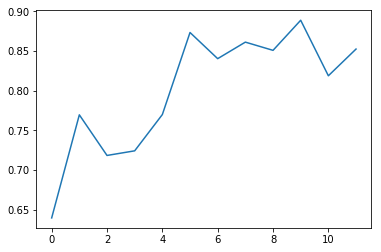

In [181]:
plt.plot(history.history['val_acc'])

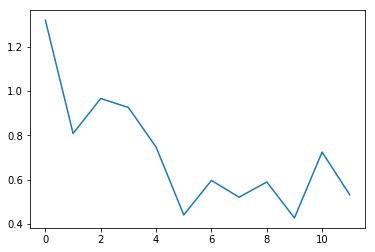

In [183]:
plt.plot(history.history['val_loss'])

* #### Reloading the model trained on training_dataset for 12 epochs to further train on 8 more epochs.

In [185]:
from keras.models import load_model
model = load_model('model0.88_val_accuracy.hdf5')

In [186]:
sc= model.evaluate(xtest, ytest, batch_size=128)

2399/2399 [==============================] - 7s 3ms/step


In [190]:
print('Val loss and accuracy from 12 epochs of training:',sc[0],' ', sc[1])

Val loss and accuracy from 12 epochs of training: 0.4275117438999302   0.888703627181878


In [191]:
import time
tick = time.time()

history_8epochs = comp_model.fit_generator(train_generator, validation_data=test_generator, nb_val_samples=xtest.shape[0], samples_per_epoch=xtrain.shape[0], nb_epoch=8, verbose=1, callbacks=[lr_scheduler,tbcallback, checkpointer])

print('total training & validation time for 22500 training images and 7500 test images: ', time.time()- tick)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=337, epochs=8, validation_steps=2399)`
  after removing the cwd from sys.path.


Epoch 1/8
337/337 [==============================] - 381s 1s/step - loss: 0.1084 - acc: 0.9706 - val_loss: 0.4155 - val_acc: 0.9046

Epoch 00001: val_loss improved from 0.42735 to 0.41553, saving model to model4.01-0.42.hdf5
Epoch 2/8
337/337 [==============================] - 379s 1s/step - loss: 0.1105 - acc: 0.9702 - val_loss: 0.3691 - val_acc: 0.9079

Epoch 00002: val_loss improved from 0.41553 to 0.36914, saving model to model4.02-0.37.hdf5
Epoch 3/8
337/337 [==============================] - 380s 1s/step - loss: 0.1035 - acc: 0.9730 - val_loss: 0.3549 - val_acc: 0.9175

Epoch 00003: val_loss improved from 0.36914 to 0.35485, saving model to model4.03-0.35.hdf5
Epoch 4/8
337/337 [==============================] - 378s 1s/step - loss: 0.0918 - acc: 0.9746 - val_loss: 0.8953 - val_acc: 0.8087

Epoch 00004: val_loss did not improve
Epoch 5/8
337/337 [==============================] - 378s 1s/step - loss: 0.0836 - acc: 0.9788 - val_loss: 0.4259 - val_acc: 0.9083

Epoch 00005: val_loss

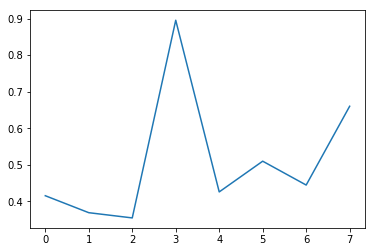

In [192]:
plt.plot(history_8epochs.history['val_loss'])

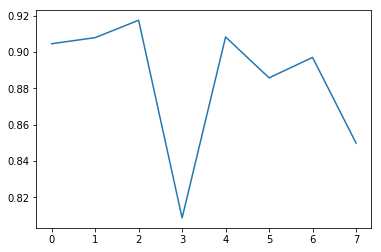

In [193]:
plt.plot(history_8epochs.history['val_acc'])